seat rotation
---

partners sat in seat X one day, then seat X+1, then X+2...
"Tony" liked seat 24. So everyone skipped 24.

>David,
>
>Here’s the seat rotation plan we used in NZ.   According to the guide, it was determined by some mathematician.  Our number was 22.  The first day I was 5 seats behind the driver, the next day we moved to #23.  “Tony” liked to sit way in the back so we all skipped 24 , then went to #1 spot.
>
>And as I mentioned , there were a few open seats so Dad & I would split up to have more space.  Of course,  people forgot where they sat and sometimes caused confusion  :) !  Anyway, it was good to have some kind of plan so the same people didn’t always get the front  / best view.
>
>Do you think it is just random?

![seat](seats.png)

Give each seat a row and a side.

In [1]:
seat_numbers = ['Driver', 'Front Door',1,14,18,10,7,21,15,4,22,8,16,'toilet',3,'back door',9,12,5,23,20,17,11,2,19,6,24,13]

rows = [ [row, row] for row in range(14)]
rows = [ row_num
        for row in rows
        for row_num in row
       ]
RLs = [ ['R', 'L'] for row in range(14)]
RLs = [ side
       for row in RLs
       for side in row ]
seats = {
    seat_number:{
        'row':row,
        'side':side,
        'side_no':(0 if side == 'L' else 1)
    }
    for seat_number, row, side in zip(seat_numbers, rows, RLs)
}

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def get_seat_position(seat_key):
    seat = seats[seat_key]
    row = seat['row']
    side_no = seat['side_no']
    return [row, side_no]

def seat_distance(seat1, seat2):
    position1 = np.array(get_seat_position(seat1))
    position2 = np.array(get_seat_position(seat2))
    return np.linalg.norm(position2-position1)

In [3]:
distances = [ [seat1, seat2, seat_distance(seat1, seat2)]
             for seat1 in seats
             for seat2 in seats
            ]

# # sns.heatmap(distances)


<Axes: >

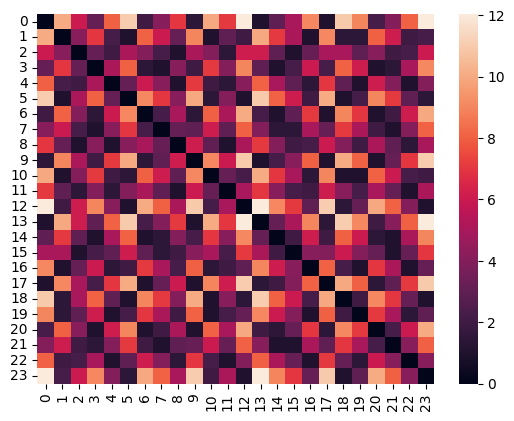

In [4]:
import pandas as pd
df = pd.DataFrame(distances, columns = ['seat1','seat2','distance'])
sorted_distance_df = df.where(~((df == 'toilet') | (df == 'back door')|(df == 'Driver')|(df == 'Front Door')), other = np.nan).dropna().sort_values(by = ['seat1','seat2']).astype(float)
distance_matrix = sorted_distance_df.to_numpy()
distance_matrix = distance_matrix[:,2].reshape((24,24)).astype(float)

sns.heatmap(sorted_distance_df['distance'].to_numpy().reshape((24,24)))

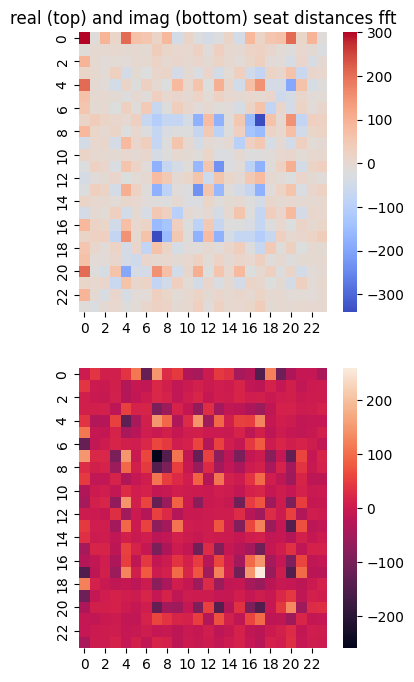

In [5]:
#create the fft
distfft = np.fft.fft2(distance_matrix)

#set up a figure
fig, ax = plt.subplots(figsize = (4,8), nrows = 2, ncols=1)

realmap = sns.heatmap(np.real(distfft), ax=ax[0], vmax = 300, cmap='coolwarm')
realmap.set_title("real (top) and imag (bottom) seat distances fft")

immap = sns.heatmap(np.imag(distfft), ax = ax[1])
# immap.set_title("imag part seat distances fft")
plt.show()

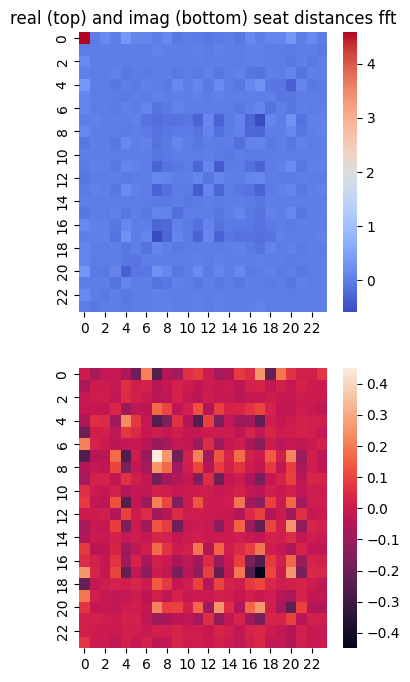

In [6]:
#create the fft
invdistfft = np.fft.ifft2(distance_matrix)

#set up a figure
fig, ax = plt.subplots(figsize = (4,8), nrows = 2, ncols=1)

invrealmap = sns.heatmap(np.real(invdistfft), ax=ax[0], cmap='coolwarm')
invrealmap.set_title("real (top) and imag (bottom) seat distances fft")

invimmap = sns.heatmap(np.imag(invdistfft), ax = ax[1])
# immap.set_title("imag part seat distances fft")
plt.show()

In [7]:
def get_neighbors(seat, include_toilet = False):
    """give a seat key. Get the keys of its neighbors.
    Optionally include non-seats."""
    this_seat = seats[seat]
    this_row = this_seat['row']
    this_side = this_seat['side']
    #get forward and back neighbors
    f_b_neighbors = [
        neighbor for neighbor in seats
        if seats[neighbor]['side'] == this_side and abs(seats[neighbor]['row'] - this_row) == 1
    ]
    #get neighbor to the side
    side_neighbor = [
        neighbor for neighbor in seats
        if seats[neighbor]['side'] != this_side and seats[neighbor]['row'] == this_row
    ]
    if include_toilet:
        return f_b_neighbors + side_neighbor
    else:
        return [
            neighbor for neighbor in f_b_neighbors + side_neighbor
            if type(neighbor) != str
        ]

In [8]:
get_neighbors(5)

[9, 20, 23]

In [9]:
get_neighbors('Driver')

[1]

In [10]:
get_neighbors('Driver', True)

[1, 'Front Door']

In [11]:
# this doesn't work because it messes up the cycling and stuff idk. Look later for thi solution to this.

# def get_previous_neighbor_distances(seat:int):
#     """Given a seat, look back at the seat sat in the previous cycle.
#     Get its neighbors, and find the seats they are in one
#     cycle ahead. Get the distances between these."""
#     last_seat = (seat - 1)%24
#     last_seat_neighbors = get_neighbors(last_seat)
#     new_distances = []
#     for old_neighbor in last_seat_neighbors:
#         new_seat = (old_neighbor + 1)%24
#         new_distance = seat_distance(new_seat, seat)
#         new_distances.append(new_distance)
#     return np.array(new_distances)

In [12]:
get_previous_neighbor_distances(3)

array([5.        , 4.        , 1.41421356])

In [13]:
seat_df = pd.DataFrame(seats).T
# seat_df['neighbors']

In [14]:
seat_df['neighbors'] = seat_df.reset_index()['index'].apply(lambda ind: get_neighbors(ind, True))

In [15]:
seat_df['neighbors_no'] = seat_df.reset_index()['index'].apply(lambda ind: get_neighbors(ind, False))

In [38]:
def mod_offset(a, n, d):
    """a mod n with window offset d"""
    moffset = a-n*((a-d)//n)
    return moffset

In [70]:
seat_df['seat'] = seat_df.index
seat_df['previous_seat'] = seat_df['seat'].apply(lambda seat: mod_offset(seat-1,24,1) if type(seat) != str else np.nan)
seat_df['previous_neighbors'] = seat_df['previous_seat'].dropna().apply(get_neighbors)

In [72]:
seat_df

,row,side,side_no,neighbors,neighbors_no,previous_neighbors,previous_seat,seat
Driver,0,R,1,NaN,NaN,NaN,NaN,Driver
Front Door,0,L,0,NaN,NaN,NaN,NaN,Front Door
1,1,R,1,"[14, Driver]",[14],"[19, 13]",24.0,1
14,1,L,0,"[16, 9, back door]","[16, 9]","[6, 24]",13.0,14
18,2,R,1,"[9, 20, 23]","[9, 20, 23]","[23, 2, 20]",17.0,18
10,2,L,0,"[15, 16, 8]","[15, 16, 8]","[3, 5, 12]",9.0,10
7,3,R,1,"[10, 4, 7]","[10, 4, 7]","[2, 13, 19]",6.0,7
21,3,L,0,"[23, 2, 20]","[23, 2, 20]","[5, 11, 17]",20.0,21
15,4,R,1,"[toilet, 12, 3]","[12, 3]","[10, 1]",14.0,15
4,4,L,0,"[1, 7, 10]","[1, 7, 10]","[16, 9]",3.0,4


In [74]:
#cycle previous neighbors ahead.
def cycle_previous_neighbors(neighbors):
    new_neighbor_locations = [
        mod_offset(neighbor + 1, 24, 1)
        for neighbor in neighbors
    ]
    return new_neighbor_locations

seat_df['previous_neighbors_plus1'] = seat_df['previous_neighbors'].dropna().apply(cycle_previous_neighbors)
seat_df
        

,row,side,side_no,neighbors,neighbors_no,previous_neighbors,previous_seat,seat,previous_neighbors_plus1
Driver,0,R,1,NaN,NaN,NaN,NaN,Driver,NaN
Front Door,0,L,0,NaN,NaN,NaN,NaN,Front Door,NaN
1,1,R,1,"[14, Driver]",[14],"[19, 13]",24.0,1,"[20, 14]"
14,1,L,0,"[16, 9, back door]","[16, 9]","[6, 24]",13.0,14,"[7, 1]"
18,2,R,1,"[9, 20, 23]","[9, 20, 23]","[23, 2, 20]",17.0,18,"[24, 3, 21]"
10,2,L,0,"[15, 16, 8]","[15, 16, 8]","[3, 5, 12]",9.0,10,"[4, 6, 13]"
7,3,R,1,"[10, 4, 7]","[10, 4, 7]","[2, 13, 19]",6.0,7,"[3, 14, 20]"
21,3,L,0,"[23, 2, 20]","[23, 2, 20]","[5, 11, 17]",20.0,21,"[6, 12, 18]"
15,4,R,1,"[toilet, 12, 3]","[12, 3]","[10, 1]",14.0,15,"[11, 2]"
4,4,L,0,"[1, 7, 10]","[1, 7, 10]","[16, 9]",3.0,4,"[17, 10]"


In [84]:
def get_distance_list(this_seat, neighbors):
    seat_distances = [
        seat_distance(this_seat, neighbor)
        for neighbor in neighbors
    ]
    return seat_distances

seat_df['previous_neighbors_plus1_distances'] = seat_df.dropna(subset='previous_neighbors_plus1').apply(
    lambda row: get_distance_list(row.seat,row.previous_neighbors_plus1), axis = 1
)

seat_df

,row,side,side_no,neighbors,neighbors_no,previous_neighbors,previous_seat,seat,previous_neighbors_plus1,previous_neighbors_plus1_distances
Driver,0,R,1,NaN,NaN,NaN,NaN,Driver,NaN,NaN
Front Door,0,L,0,NaN,NaN,NaN,NaN,Front Door,NaN,NaN
1,1,R,1,"[14, Driver]",[14],"[19, 13]",24.0,1,"[20, 14]","[9.0, 1.0]"
14,1,L,0,"[16, 9, back door]","[16, 9]","[6, 24]",13.0,14,"[7, 1]","[2.23606797749979, 1.0]"
18,2,R,1,"[9, 20, 23]","[9, 20, 23]","[23, 2, 20]",17.0,18,"[24, 3, 21]","[11.0, 5.0, 1.4142135623730951]"
10,2,L,0,"[15, 16, 8]","[15, 16, 8]","[3, 5, 12]",9.0,10,"[4, 6, 13]","[2.0, 10.0, 11.0]"
7,3,R,1,"[10, 4, 7]","[10, 4, 7]","[2, 13, 19]",6.0,7,"[3, 14, 20]","[4.0, 2.23606797749979, 7.0]"
21,3,L,0,"[23, 2, 20]","[23, 2, 20]","[5, 11, 17]",20.0,21,"[6, 12, 18]","[9.0, 5.0, 1.4142135623730951]"
15,4,R,1,"[toilet, 12, 3]","[12, 3]","[10, 1]",14.0,15,"[11, 2]","[7.0, 7.0710678118654755]"
4,4,L,0,"[1, 7, 10]","[1, 7, 10]","[16, 9]",3.0,4,"[17, 10]","[6.0, 2.0]"


In [89]:
np.std([12,35,21])

np.float64(9.46337971105226)

In [90]:
seat_df['previous_plus1_mean'] = seat_df['previous_neighbors_plus1_distances'].dropna().apply(lambda distances: sum(distances)/(len(distances)))
seat_df['previous_plus1_std'] = seat_df['previous_neighbors_plus1_distances'].dropna().apply(lambda distances: np.std(distances))

seat_df

,row,side,side_no,neighbors,neighbors_no,previous_neighbors,previous_seat,seat,previous_neighbors_plus1,previous_neighbors_plus1_distances,previous_plus1_mean,previous_plus1_std
Driver,0,R,1,NaN,NaN,NaN,NaN,Driver,NaN,NaN,NaN,NaN
Front Door,0,L,0,NaN,NaN,NaN,NaN,Front Door,NaN,NaN,NaN,NaN
1,1,R,1,"[14, Driver]",[14],"[19, 13]",24.0,1,"[20, 14]","[9.0, 1.0]",5.000000,4.000000
14,1,L,0,"[16, 9, back door]","[16, 9]","[6, 24]",13.0,14,"[7, 1]","[2.23606797749979, 1.0]",1.618034,0.618034
18,2,R,1,"[9, 20, 23]","[9, 20, 23]","[23, 2, 20]",17.0,18,"[24, 3, 21]","[11.0, 5.0, 1.4142135623730951]",5.804738,3.954536
10,2,L,0,"[15, 16, 8]","[15, 16, 8]","[3, 5, 12]",9.0,10,"[4, 6, 13]","[2.0, 10.0, 11.0]",7.666667,4.027682
7,3,R,1,"[10, 4, 7]","[10, 4, 7]","[2, 13, 19]",6.0,7,"[3, 14, 20]","[4.0, 2.23606797749979, 7.0]",4.412023,1.966568
21,3,L,0,"[23, 2, 20]","[23, 2, 20]","[5, 11, 17]",20.0,21,"[6, 12, 18]","[9.0, 5.0, 1.4142135623730951]",5.138071,3.098423
15,4,R,1,"[toilet, 12, 3]","[12, 3]","[10, 1]",14.0,15,"[11, 2]","[7.0, 7.0710678118654755]",7.035534,0.035534
4,4,L,0,"[1, 7, 10]","[1, 7, 10]","[16, 9]",3.0,4,"[17, 10]","[6.0, 2.0]",4.000000,2.000000


<Axes: xlabel='previous_plus1_mean', ylabel='previous_plus1_std'>

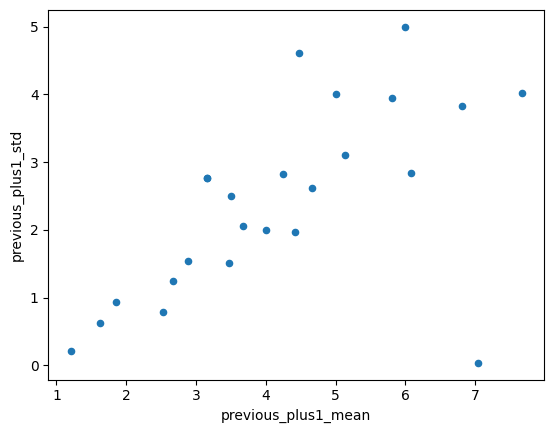

In [91]:
seat_df.plot('previous_plus1_mean', 'previous_plus1_std', kind = 'scatter')

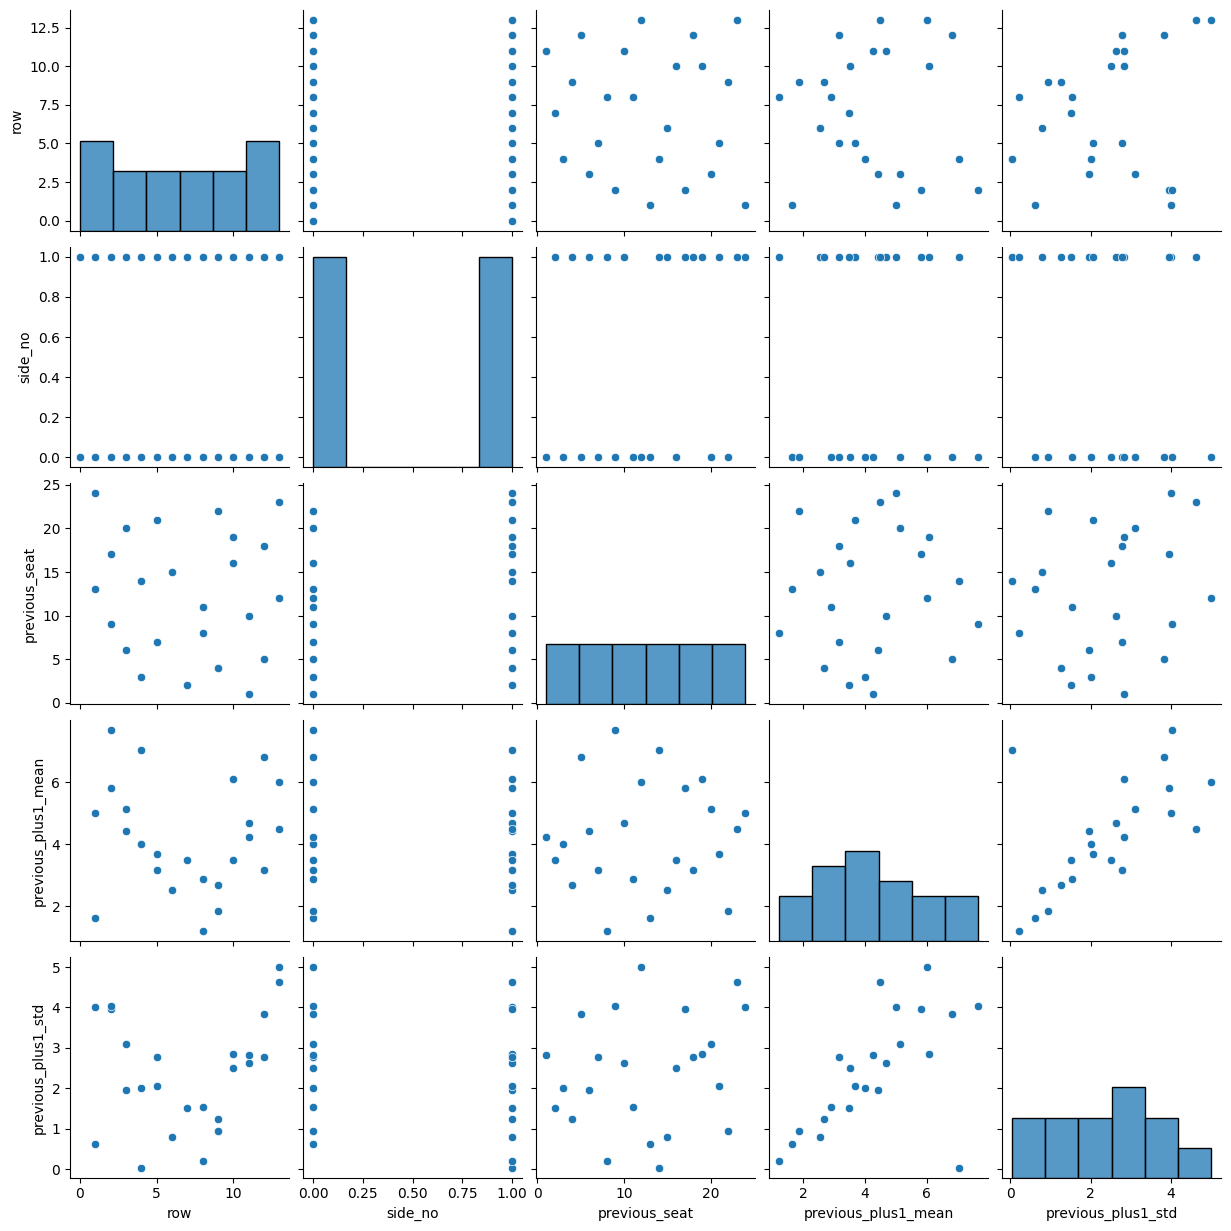

In [96]:

sns.pairplot(seat_df)

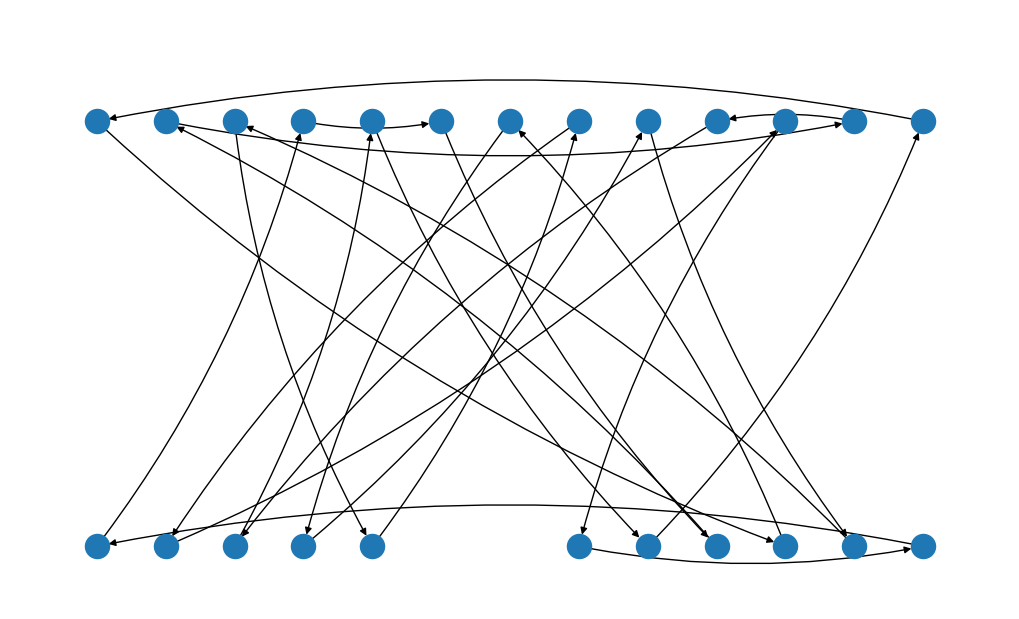

In [121]:
#look at a directed graph of the movement.

import networkx as nx

edges = [
    [x, mod_offset(x+1, 24, 1)]
    for x in range(1,25)
]

g = nx.from_edgelist(edges, create_using = nx.DiGraph)

pos = {
    index:[int(thing.row), 5*int(thing.side_no)]
    for index, thing in seat_df.iterrows()
}

plt.figure(figsize = (10,6))
nx.draw(g, pos = pos,
    connectionstyle="arc3,rad=.1" )

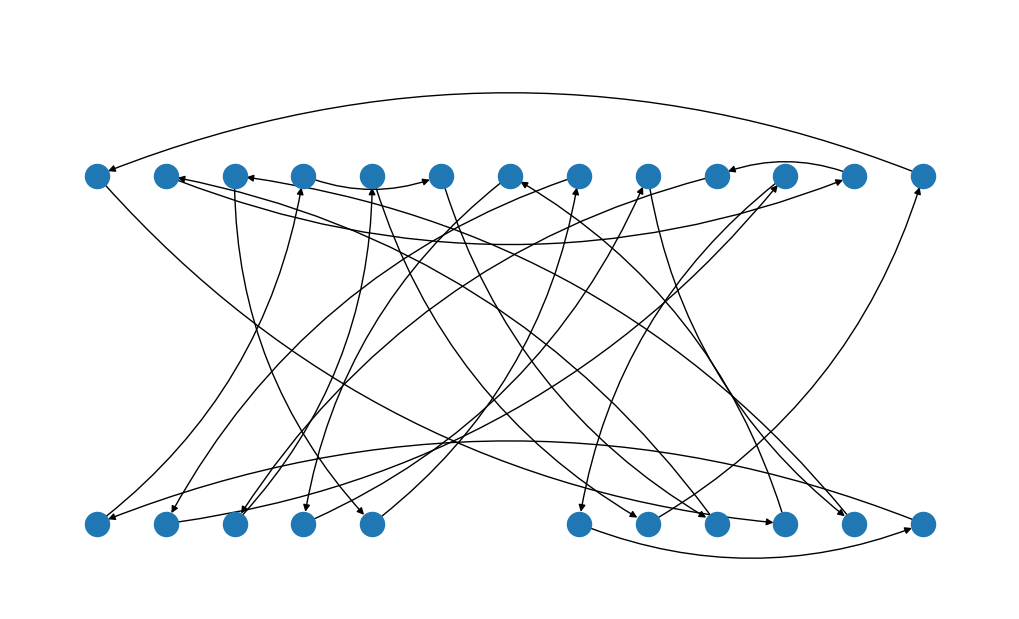

In [122]:
plt.figure(figsize = (10,6))
nx.draw(g, pos = pos,
    connectionstyle="arc3,rad=.2" )

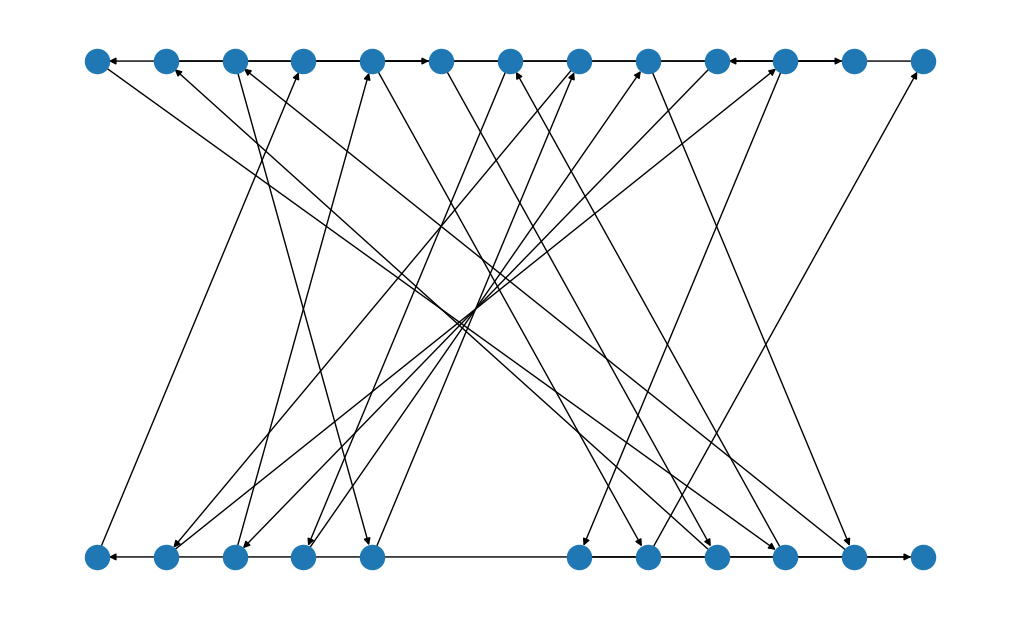

In [120]:
plt.figure(figsize = (10,6))
nx.draw(g, pos = pos)

array([[<Axes: title={'center': 'previous_plus1_mean'}>]], dtype=object)

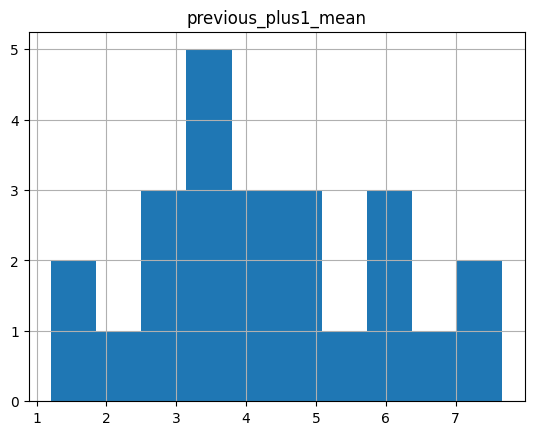

In [123]:
seat_df.hist('previous_plus1_mean')

(array([24.,  6.,  4.,  4.,  4.,  4.,  8.,  0.,  4.,  6.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <BarContainer object of 10 artists>)

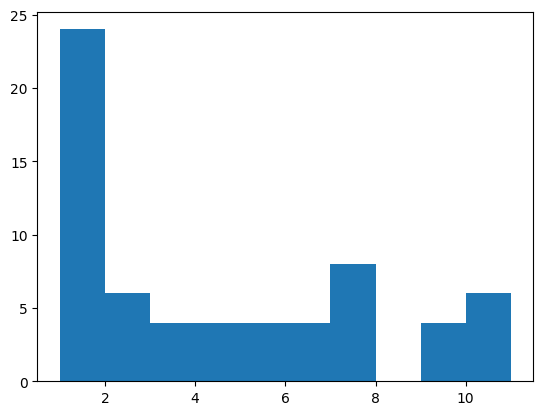

In [132]:
plt.hist(np.hstack(seat_df['previous_neighbors_plus1_distances'].dropna().to_numpy()))

In [134]:
np.hstack(seat_df['previous_neighbors_plus1_distances'].dropna().to_numpy())

array([ 9.        ,  1.        ,  2.23606798,  1.        , 11.        ,
        5.        ,  1.41421356,  2.        , 10.        , 11.        ,
        4.        ,  2.23606798,  7.        ,  9.        ,  5.        ,
        1.41421356,  7.        ,  7.07106781,  6.        ,  2.        ,
        6.        ,  4.        ,  1.        ,  7.07106781,  1.41421356,
        1.        ,  1.41421356,  3.16227766,  3.        ,  5.        ,
        4.        ,  1.41421356,  1.        ,  1.41421356,  5.        ,
        2.23606798,  1.41421356,  4.        ,  1.        ,  3.        ,
        3.16227766,  1.        ,  1.41421356,  2.23606798,  9.        ,
        7.        ,  1.        ,  6.        ,  7.        ,  6.        ,
        1.        ,  1.41421356,  7.07106781,  1.41421356,  7.07106781,
        1.        , 10.        ,  9.        ,  1.41421356,  1.        ,
       11.        ,  1.41421356,  1.        , 11.        ])